# Un'analisi IRT dei quesiti del Bebras italiano

L'*Item Response Theory* (IRT) è una tecnica statistica che si propone di stimare l'*abilità* dei soggetti cui viene sottoposto un test composto da una serie di domande (dette *item*). L'abilità è un tratto *latente*, cioè non osservabile direttamente: l'aver risposto correttamente a molte domande può dipendere sia da elevata abilità, che dalla "facilità" delle domande. La stima si basa quindi su un *modello matematico* (detto *Item Response Function*) della relazione fra abilità e probabilità di rispondere correttamente alla domanda.

Il modello usato in questa analisi è una curva *logistica*, la cui forma è regolata da tre parametri $a, b, c$.
$$ p_i(\theta_j) = c_i + \frac{(1 - c_i)}{1+ e^{-b_i\cdot(\theta_j - a_i)}} $$
La probabilità $p$ di successo in un *item* $i$ è funzione dell'abilità $\theta$ del solutore $j$. I tre parametri modellano le caratteristiche dell'*item*:
- $a$, detto *difficoltà* dell'item: determina il livello di abilità necessaria per avere il 50% di probabilità di successo;
- $b$, detto *differenziazione*: determina quanto influiscono le variazioni di abilità sulla probabilità di successo;
- $c$: fissa una probabilità minima di successo per qualsiasi abilità, dovuta per esempio alla possibilità di scegliere casualmente la risposta giusta ($c$ sarà 0 per un *item* a risposta completamente aperta)

In [6]:
logistic <- function(theta, a=0, b=1, c=0) { 
    c + (1-c)/(1 + exp(-b*(theta-a)))
}

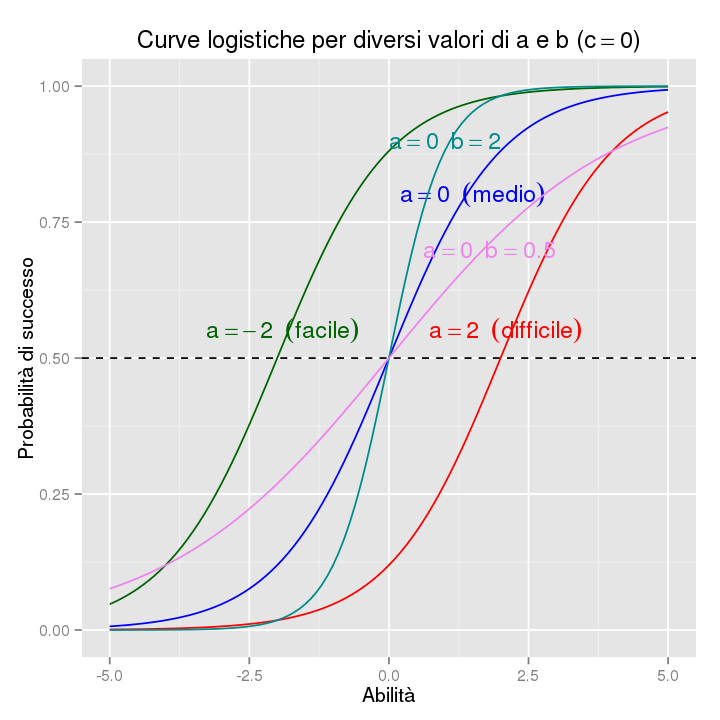

In [7]:
library("ggplot2")
data <- data.frame(x=seq(-5,5,.1))
data <- transform(data, 
                  y_mean = logistic(x), 
                  y_hard = logistic(x,a=2), 
                  y_easy=logistic(x,a=-2),
                  y_hdiscrimination=logistic(x,b=2),
                  y_ldiscrimination=logistic(x,b=.5)
                 );

options(repr.plot.width=6, repr.plot.height=6)
p <- ggplot(data, aes(x=x))
p <- p + scale_x_continuous()
p <- p + geom_hline(yintercept=0.5, linetype="dashed")
p <- p + geom_line(aes(y=y_hard), color="red")
p <- p + annotate("text", x=2.1, y=.55, label="a == 2 ~~(plain(difficile))", parse=TRUE, color="red")
p <- p + geom_line(aes(y=y_easy), color="dark green")
p <- p + annotate("text", x=-1.9, y=.55, label="a == -2 ~~(plain(facile))", parse=TRUE, color="dark green")
p <- p + geom_line(aes(y=y_mean), color="blue")
p <- p + annotate("text", x=1.5, y=.8, label="a == 0 ~~(plain(medio))", parse=TRUE, color="blue")
p <- p + geom_line(aes(y=y_hdiscrimination), color="dark cyan")
p <- p + annotate("text", x=1, y=.9, label="a == 0 ~~ b == 2", parse=TRUE, color="dark cyan")
p <- p + geom_line(aes(y=y_ldiscrimination), color="violet")
p <- p + annotate("text", x=1.8, y=.7, label="a == 0 ~~ b == .5", parse=TRUE, color="violet")
p <- p + labs(title=expression(paste("Curve logistiche per diversi valori di ", a, " e ", b, " (",c==0,")")), 
              x="Abilità", y="Probabilità di successo")

p
rm(data, p)

A ogni *item* o quiz, quindi, viene associata una specifica curva logistica (la sua *item response function*) che può essere dedotta osservando un campione di risolutori cui è stato sottoposto il test. A questo scopo i parametri relativi ai quiz del Bebras italiano 2015 sono stati stimati con un approccio bayesiano, come descritto in [C. Bellettini et al. *"How challenging are Bebras tasks? an IRT analysis based on the performance of Italian students", Proceedings of the 20th annual conference on innovation and technology in computer science education ITiCSE'15* (Vilnius, Lithuania, 2015)](http://dx.doi.org/10.1145/2729094.2742603). I dettagli statistici riguardo la bontà di adattamento del modello sono disponibili [qui](https://mmonga.shinyapps.io/bebrasIT2015).

## I quesiti 2015

In [8]:
library("rstan"); rstan_options(auto_write = TRUE); options(mc.cores = parallel::detectCores())
load("fit.RData") # carica l'oggetto fit
dfit <- as.data.frame(fit)
obs <- read_rdump("bebras-all.data.R")
source("qnames.R")

cats <- c("kilo", "mega", "giga", "tera", "peta")
categories <- factor(cats, levels=cats, ordered = TRUE)
rm(cats)

Loading required package: Rcpp
rstan (Version 2.8.0, packaged: 2015-09-19 14:48:38 UTC, GitRev: 05c3d0058b6a)
For execution on a local, multicore CPU with excess RAM we recommend calling
rstan_options(auto_write = TRUE)
options(mc.cores = parallel::detectCores())


In [9]:
obs$rcats <- plyr::aaply(obs$rquiz, 1, function (e){ as.character(categories[ ((e - 1) %/% 15) + 1 ]) })

In [10]:
library("dplyr")
teams <- data.frame(id = obs$rtaker, category = obs$rcats) %>% distinct()
get_par_df <- function(df, par, table) {
    df %>% 
    dplyr::select(contains(par)) %>% 
    tidyr::gather(key = "parameter", value, everything()) %>%
    dplyr::mutate("id" = as.numeric(regmatches(parameter, regexpr("[0-9]+",parameter)))) %>%
    dplyr::left_join(table, by = "id") %>%
    transform(category = factor(category, levels=levels(categories), ordered = TRUE))
}


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [11]:
team_ability <- get_par_df(dfit, "ability", teams)

Il modello è tarato in modo che la media delle abilità di tutte le squadre partecipanti sia 0.

In [12]:
summary(team_ability$value)

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
-5.616000 -0.722700  0.002395  0.000000  0.723700  5.662000 

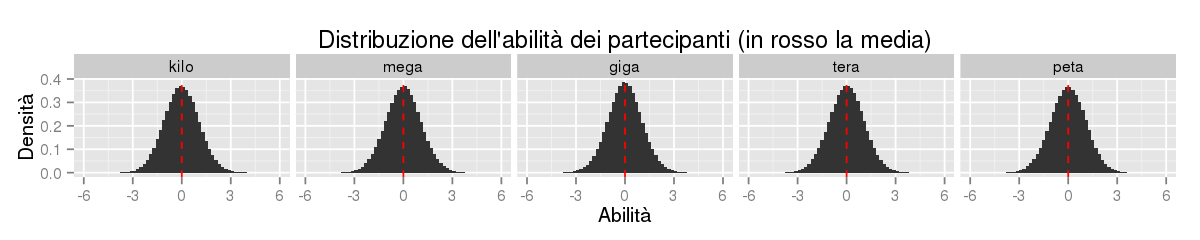

In [13]:
options(repr.plot.width=10, repr.plot.height=2)
p <- ggplot(team_ability, aes(x=value)) 
p <- p + geom_histogram(binwidth=.2) 
p <- p + aes(y=..density..)
p <- p + facet_grid(. ~ category)
p <- p + geom_vline(aes(xintercept=mean(value)), linetype="dashed", colour="red")
p <- p + labs(title="Distribuzione dell'abilità dei partecipanti (in rosso la media)", 
              x="Abilità", y="Densità")
p
rm(p)

In [89]:
quizzes <- data.frame(id = 1:length(qnames), quiz = qnames, 
                      category = factor(plyr::laply(strsplit(qnames, "_"), function(e){tolower(e[2])}), 
                                        levels=levels(categories), ordered = TRUE),
                      ord = plyr::laply(strsplit(qnames, "_"), function(e){e[3]}),
                      block = plyr::laply(strsplit(qnames, "_"), function(e){substr(e[3],1,1)}))
                      

In [91]:
quiz_difficulty <- get_par_df(dfit, par = "difficulty", table = quizzes)

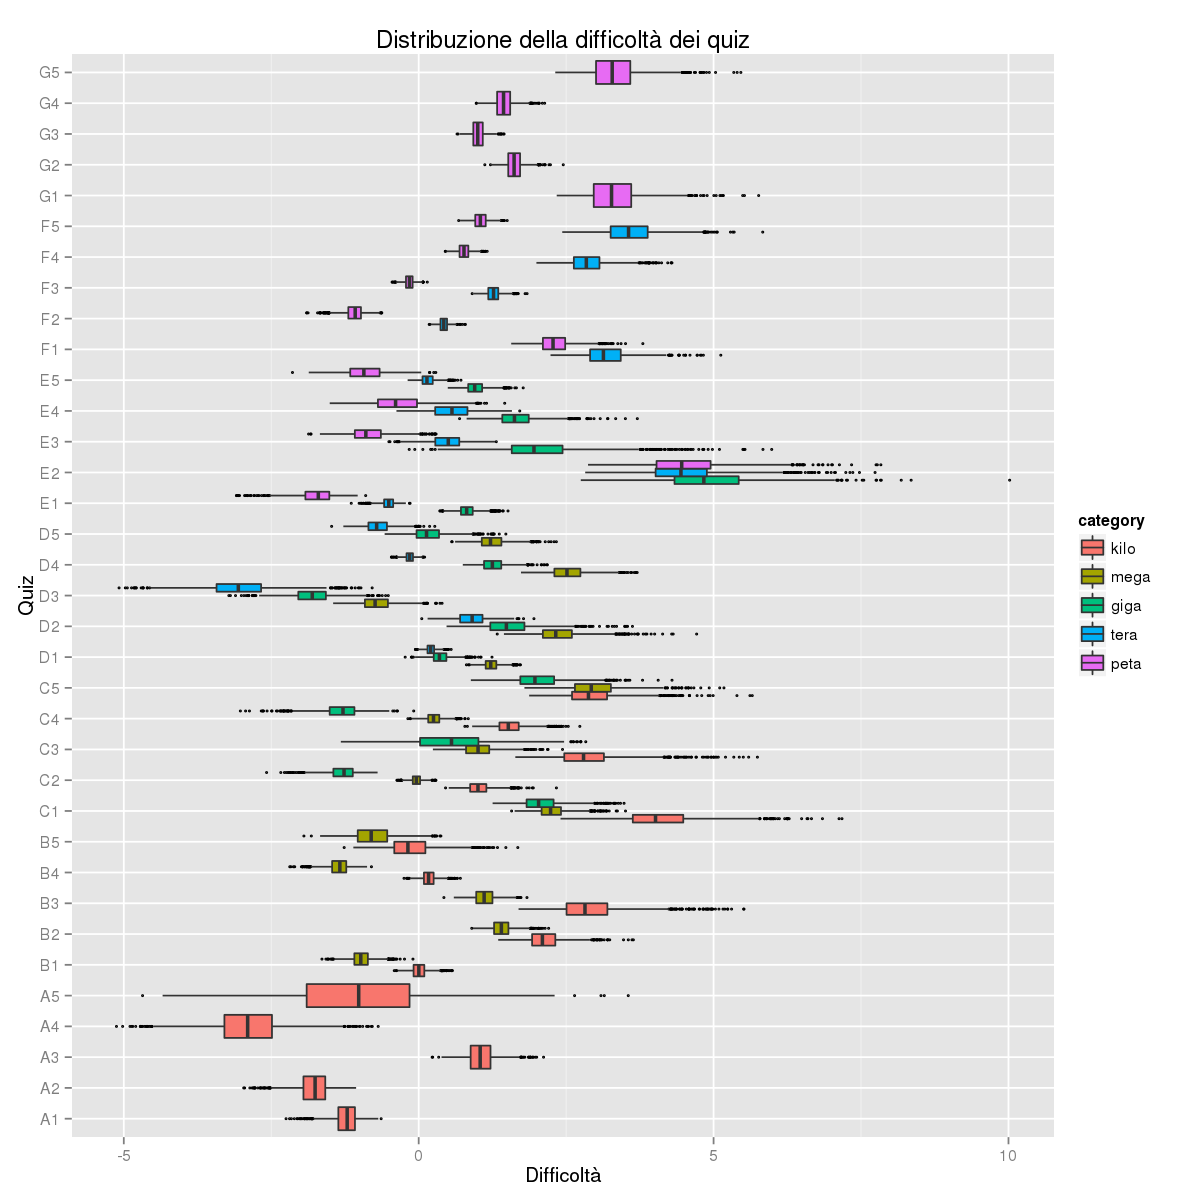

In [103]:
options(repr.plot.width=10, repr.plot.height=10)
p <- ggplot(quiz_difficulty, aes(ord, value, fill=category)) 
#p <- p + geom_histogram(binwidth=.3)
p <- p + geom_boxplot(outlier.shape = 1, outlier.size = .5) + coord_flip()
#p <- p + geom_vline(aes(xintercept=median(value)), linetype="dashed", colour="red")
p <- p + labs(title="Distribuzione della difficoltà dei quiz", 
              x="Quiz", y="Difficoltà")
p
rm(p)